# Sentiment Score Summary

Summary statistics for sentiment scores in GDELT articles: **high**, **low**, and **median**, plus count, mean, and std. Includes a breakdown by ticker.

In [6]:
import pandas as pd
from pathlib import Path

# Find project root by walking up from current directory until we find 'data' directory
# Works whether notebook is run from project root or from a subdirectory
current = Path.cwd()
while not (current / "data").exists() and current != current.parent:
    current = current.parent
PROJECT_ROOT = current
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "gdelt_articles_with_sentiment.csv"

df = pd.read_csv(INPUT_PATH, parse_dates=["seendate"])
assert "sentiment_score" in df.columns, "Input CSV must have a 'sentiment_score' column."
print(f"Loaded {len(df):,} rows from {INPUT_PATH.name}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/trevor/repos/market-sentiment-analysis/docs/eda/sprint_2/data/processed/gdelt_articles_with_sentiment.csv'

## Overall summary (all articles)

High, low, median, and other summary stats for `sentiment_score`.

In [4]:
s = df["sentiment_score"]
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
iqr = q3 - q1

print("Sentiment score summary (all articles)")
print("=" * 50)
print(f"  Count:  {len(s):,}")
print(f"  High:   {s.max():.4f}")
print(f"  Low:    {s.min():.4f}")
print(f"  Median: {s.median():.4f}")
print(f"  Mean:   {s.mean():.4f}")
print(f"  Std:    {s.std():.4f}")
print()
print("Quartiles")
print("-" * 50)
print(f"  Q1 (25%):  {q1:.4f}")
print(f"  Q2 (50%):  {q2:.4f}")
print(f"  Q3 (75%):  {q3:.4f}")
print(f"  IQR:       {iqr:.4f}")


NameError: name 'df' is not defined

## By ticker

Count, high, low, median, and mean per ticker (sorted by median descending).

In [3]:
if "ticker" in df.columns:
    by_ticker = df.groupby("ticker")["sentiment_score"].agg(
        count="count",
        high="max",
        low="min",
        median="median",
        mean="mean",
    ).sort_values("median", ascending=False)
    by_ticker
print(by_ticker)

        count      high       low  median      mean
ticker                                             
AAPL      221  0.964028 -0.905148     0.0  0.058793
AMZN      240  0.964028 -0.964028     0.0  0.103122
GOOGL     420  0.964028 -0.964028     0.0  0.132951
META      347  0.964028 -0.964028     0.0  0.072979
MSFT      278  0.964028 -0.964028     0.0  0.151811
NVDA      513  0.964028 -0.964028     0.0  0.073915
TSLA      182  0.964028 -0.964028     0.0  0.096655


## Box and whisker plot by ticker

Distribution of `sentiment_score` per ticker (box = IQR, whiskers = min/max or 1.5×IQR, line = median).

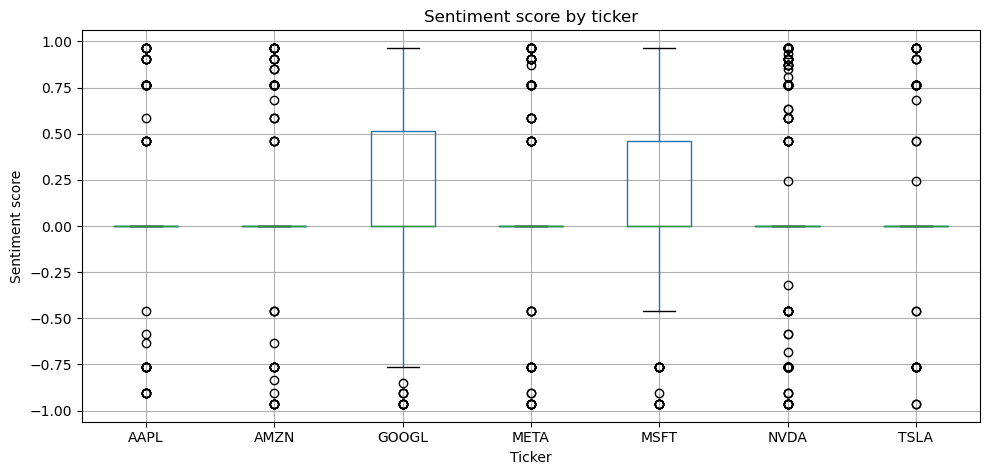

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
df.boxplot(column="sentiment_score", by="ticker", ax=ax)
ax.set_xlabel("Ticker")
ax.set_ylabel("Sentiment score")
ax.set_title("Sentiment score by ticker")
plt.suptitle("")  # remove default "Boxplot grouped by ticker"
plt.tight_layout()
plt.show()

## Quality assessment: word-bank sentiment approach

Below we use the summary stats and a quick spot-check of high- and low-scoring titles to judge whether this approach is fit for purpose.

In [5]:
# Spot-check: sample of highest- and lowest-scoring titles (face validity)
n_show = 4
top = df.nlargest(n_show, "sentiment_score")[["title", "sentiment_score", "ticker"]]
bot = df.nsmallest(n_show, "sentiment_score")[["title", "sentiment_score", "ticker"]]
print("Highest sentiment (expect positive tone):")
print(top.to_string(index=False))
print()
print("Lowest sentiment (expect negative tone):")
print(bot.to_string(index=False))
print()
# Share of articles with no sentiment words (score exactly 0)
pct_zero = (df["sentiment_score"] == 0).mean() * 100
print(f"Share of articles with score exactly 0 (no lexicon hit): {pct_zero:.1f}%")

Highest sentiment (expect positive tone):
                                                                                                                      title  sentiment_score ticker
FinancialContent - If Santa Should Fail to Call : Why the 2026 Surge Wasnt Enough to Save the  Santa Claus Rally  Indicator         0.964028   NVDA
                                                   Tesla ( NASDAQ : TSLA ) Trading 3 . 1 % Higher Following Analyst Upgrade         0.964028   TSLA
                                                             2026 will be  incredibly choppy  but these 5 stocks could soar         0.964028   MSFT
                                               Asian shares and US futures advance , as Tokyo Nikkei 225 hits a record high         0.964028   NVDA

Lowest sentiment (expect negative tone):
                                                                                                                        title  sentiment_score ticker
                          

### Sample of unmatched headlines (sentiment_score = 0)

Random sample of headlines that didn't match any sentiment words in the lexicon. These can help identify gaps in the word bank.

In [1]:
import numpy as np

# Filter for unmatched (score exactly 0)
unmatched = df[df["sentiment_score"] == 0].copy()
print(f"Total unmatched: {len(unmatched):,} ({100*len(unmatched)/len(df):.1f}%)")
print()

# Random sample (10-20 rows)
n_sample = min(20, len(unmatched))
np.random.seed(42)  # for reproducibility
sample = unmatched.sample(n=n_sample, random_state=42)

# Display with relevant columns
display_cols = ["title", "ticker", "seendate"]
if all(col in sample.columns for col in display_cols):
    sample_display = sample[display_cols].copy()
    sample_display = sample_display.sort_values("ticker")  # group by ticker for easier review
    pd.set_option("display.max_colwidth", 100)
    print(f"Random sample of {n_sample} unmatched headlines:")
    print("=" * 100)
    print(sample_display.to_string(index=False))
else:
    print("Columns not found. Available columns:", list(sample.columns))

NameError: name 'df' is not defined

### Judgment

**What the results suggest**

- **Median = 0** (overall and per ticker) and **IQR = 0** (or very small) indicate that a large fraction of headlines contain *no* words from our financial sentiment lexicon. Those get score 0, so the distribution is zero-inflated: many neutrals, and a spread of positive/negative when the lexicon fires.
- **Mean is slightly positive** (~0.05–0.15 by ticker), so when the lexicon does fire, the balance is a bit more positive than negative (or positive phrases are more frequent in titles).
- **Full range is used** (scores near ±0.96), so the normalization and lexicon can produce strong positive and strong negative scores when matching phrases appear.

**Strengths of this approach**

- **Interpretable and transparent**: no black-box model; scores come from a fixed word list and simple rules (negation, intensity).
- **Lightweight**: no ML/NLP dependencies; fast to run and easy to tune (add/remove words).
- **Domain-oriented**: lexicon is financial (e.g. surge, rally, downgrade, earnings beat), so it targets market-relevant tone.

**Limitations**

- **Title-only**: no article body, so we miss sentiment expressed only in the text.
- **Many “neutral” (0)**: headlines that are relevant but use different wording won’t match the lexicon, so we underestimate how much signal we could get.
- **No ground truth**: we have not validated against human labels or against returns; high/low might not align with actual market sentiment or price moves.
- **Context**: simple negation/intensity helps but we don’t model more complex context (e.g. “surge in concerns”).

**Verdict**

- **For exploratory use** (e.g. time series of average sentiment, comparison across tickers, or as one input to further analysis), this approach is **reasonable**: it’s interpretable, cheap, and gives a usable spread of scores.
- **For causal or predictive claims** (e.g. “sentiment causes returns” or “sentiment predicts moves”), we should **not** rely on this method alone: add spot-checks (as above), consider validating against human ratings or a benchmark, and possibly complement with a second method (e.g. VADER or FinBERT) if we need finer discrimination or body text.

**Recommendation:** Treat these scores as a *simple, interpretable signal* for exploration and visualization, and document their limitations when reporting any findings.